In [1]:
import gym
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('BipedalWalker-v3')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0005 # lr = 0.0001 for BipedalWalker-SAC
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
updates_per_step=4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)
print('updates_per_step: ', updates_per_step)

/home/dan/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


max_steps:  1600
device:  cuda:0
state dim:  24
action dim:  Box(4,)
leraning rate:  0.0005
updates_per_step:  4


In [2]:
def save(agent, directory, filename, suffix):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))

In [6]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 10001
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break
        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if i_episode % 20 == 0 and i_episode > 0:
            save(agent, 'dir_chk_lr0005', 'weights', str(i_episode))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > 300.5):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

# scores, avg_scores = sac_train(max_steps=max_steps)
memory = sac_train(max_steps=10)

Ep.: 0, Total Steps: 10, Ep.Steps: 10, Score: -1.42, Avg.Score: -1.42, Time: 00:00:00
Ep.: 1, Total Steps: 20, Ep.Steps: 10, Score: -1.01, Avg.Score: -1.21, Time: 00:00:00
Ep.: 2, Total Steps: 30, Ep.Steps: 10, Score: -0.67, Avg.Score: -1.03, Time: 00:00:00
Ep.: 3, Total Steps: 40, Ep.Steps: 10, Score: -1.90, Avg.Score: -1.25, Time: 00:00:00
Ep.: 4, Total Steps: 50, Ep.Steps: 10, Score: -1.45, Avg.Score: -1.29, Time: 00:00:00
Ep.: 5, Total Steps: 60, Ep.Steps: 10, Score: -1.06, Avg.Score: -1.25, Time: 00:00:00
Ep.: 6, Total Steps: 70, Ep.Steps: 10, Score: -1.49, Avg.Score: -1.29, Time: 00:00:00
Ep.: 7, Total Steps: 80, Ep.Steps: 10, Score: -0.92, Avg.Score: -1.24, Time: 00:00:00
Ep.: 8, Total Steps: 90, Ep.Steps: 10, Score: -1.57, Avg.Score: -1.28, Time: 00:00:00
Ep.: 9, Total Steps: 100, Ep.Steps: 10, Score: -1.74, Avg.Score: -1.32, Time: 00:00:00
Ep.: 10, Total Steps: 110, Ep.Steps: 10, Score: -1.42, Avg.Score: -1.33, Time: 00:00:00
Ep.: 11, Total Steps: 120, Ep.Steps: 10, Score: -1.

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [256, 1]], which is output 0 of TBackward, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [4]:
save(agent, 'dir_chk_lr0005', 'weights', 'final')

length of scores:  540 , len of avg_scores:  540


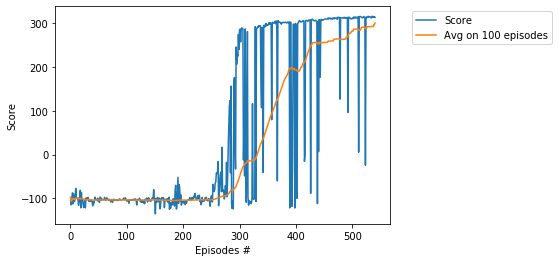

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 318.53,	Score: 318.53 	Time: 00:00:16
Episode 1	Average Score: 318.56,	Score: 318.59 	Time: 00:00:13
Episode 2	Average Score: 318.68,	Score: 318.92 	Time: 00:00:14
Episode 3	Average Score: 318.59,	Score: 318.35 	Time: 00:00:14
Episode 4	Average Score: 318.50,	Score: 318.10 	Time: 00:00:14
Episode 5	Average Score: 318.36,	Score: 317.66 	Time: 00:00:14


In [8]:
env.close()